# [Computational Social Science] 
## 3-4 BART - Solutions

In this lab, we will **Bayesian Additive Regression Trees (BART),** which is a non-linear and non-parametric Bayesian statistical modeling technique. BART can  used for regression and classification problems and it has been shown to provide flexible fits to complex datasets that often outperform traditional modeling techniques like linear regression, classification, and even some regression trees.

BART models data as a sum of decision trees where each tree is constrained by a prior to be a weak learner, contributing a small amount to the overall prediction. This setup helps avoid overfitting, which can be an issue  with methods that use decision trees, such as random forests.

In more technical terms, given an outcome variable Y and a vector of predictor variables X1, X2, ..., Xp, BART assumes the following relationship:

`Y = f(X1, X2, ..., Xp) + e`

where f(X1, X2, ..., Xp) is some unknown function and *e* is a normally distributed error term. BART approximates the unknown function *f* using an additive model of binary trees. The "Bayesian" part of BART comes in in how it uses Bayesian statistical principals to learn from the data and make predictions, while also providing a way to do statistical inference. 

## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This helps to prevent conflicts between dependencies across different projects and ensures that you are using the correct versions of packages. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. 

<br>

If you have already created a virtual enviornment, you can run the following command to activate it: 

<br>

`conda activate <virtual_env_name>`

<br>

For example, if your virtual environment was named as CSS, run the following command. 

<br>

`conda activate CSS`

<br>

To deactivate your virtual environment after you are done working with the lab, run the following command. 

<br>

`conda deactivate`

<br>

## Libraries and environment settings


Let's get started by importing some libraries and specfying some settings for our environment.

In [1]:
# Uncomment & install if pymc and pymc_bart is not already installed in your machine
#!pip install pymc
#!pip install pymc_bart

In [2]:
# import libraries
# ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az                 # ArviZ is a Python package for exploratory analysis of Bayesian models
import pymc as pm                  # PyMC (formerly PyMC3) is a Python package for Bayesian statistical modeling
import pymc_bart as pmb            # PyMC-BART extends PyMC 
import warnings

# import sub-modules
from sklearn.model_selection import train_test_split

# run this command to suppress sampling notifications
warnings.filterwarnings("ignore")

# Since the library we use for BART modeling (PyMC) might not work in older versions, let's print our the version 
print(f"Running on PyMC v{pm.__version__}") 

Running on PyMC v5.9.0


In [3]:
# set random seed
# ----------
# this is a slightly different but more efficient way to see a random seed bc you can call 
# the object "random_seed" later in the script but only change it once at the top of the script
random_seed = 300 
np.random.seed(random_seed)

# settings for ArviZ (which is specifically used to visualize Bayesian models)
az.style.use("arviz-darkgrid")

### Data and pre-processing

In this lab, we will first use coal mining disaster dataset. This is a popular dataset in the [PYMC library documentation](https://www.pymc.io/projects/bart/en/latest/examples/BART_introduction.html) used to illustrate some basic principals of BART modeling. We will discretize the dataset by building a histogram and use center of bins as x variable and counts per bin as y variable. 

The file "coal.csv" comes when you load the `PyMC` library. The `numpy.loadtxt()` function expects the file to be a text file with numerical data, and will load the data into a NumPy array called `coal.` 

*Note that the file is a .csv file, which stands for comma delimited value.*

In [4]:
# Load the coal mining disaster data
coal = np.loadtxt(pm.get_data("coal.csv")) 

# Convert the data to a pandas DataFrame so we can take a quick look
coal_data = pd.DataFrame(coal)

# Now `coal_data` is a pandas DataFrame containing the coal mining disaster data.
coal_data

,0
0,1851.2026
1,1851.6324
2,1851.9692
3,1851.9747
4,1852.3142
...,...
186,1947.6872
187,1951.4052
188,1957.8830
189,1960.4894


This is a bit weird, the `coal` dataframe we just loaded only has one column-which corresponds to dates of coal mining disaters. 

So, to get some predcitors we can use, we are going to discretize the data, just as if we were building a histogram. Specifically, we are going to use the centers of the bins as the **X** variable and the counts per bin as the **y** variable.

In [5]:
#
# Discretize data
# ---------------------------------------------------------

# STEP 1:
# --------
# Let's first calculate the range of the data. 
# If the coal dataset represents years, this would give the number of years the data spans.
years = int(coal.max() - coal.min()) 


# STEP 2:
# --------
# Let's calculate the number of bins per year we want to used to divide our data. 
# The '//' calculates the number of bins for the histogram by performing floor division,
# where the  "//" operator divides and rounds down to the nearest whole number.
bins = years // 4 

# STEP 3:
# --------
# This line creates an object "hist" that is an array with the number of
# elements in each bin, and "x_edges" is an array with the edge values of those bins.
# compute the location of the centers of the discretized data
hist, x_edges = np.histogram(coal, 
                             bins=bins) 

# STEP 4:
# --------
# This step calculates the centers of each bin by adding half the bin width 
# to the left edge of each bin (x_edges[:-1]). This is done to represent each 
# bin by its center point rather than its edges.
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2

# STEP 5:
# --------
# This step converts "x_centers" object into a 2D array with one column. 
# The None indexing is used to add an extra dimension. This is done because the BART  
# model expects 2D input.
x_data = x_centers[:, None] 


# STEP 6:
# --------
# just renames hist to y_data. This data represents the counts in each bin 
# or the number of disasters per year.
y_data = hist

### Fitting a model

Now that we have a predictor (y_data), we are going to fit that to our outcome. A few things to note. The PyMC library has a different syntax for fitting a model. We'll use the `with pm.model() as model_coal:` as the syntax to run the model. Keep in mind that everything that happens within the with block pertains to this "model_coal".


**Setting `m` parameter:**
One important parameter of these models is `m`, which is the number of trees we are going to over. A low number of trees like 20 could be good enough for simple models like this and could also work very good as a quick approximation for more complex models. This is particularly helpful during early stage modeling when we may want to try a few things as quickly as possible in order to better grasp which model may be best for our problem. In those cases once we have more certainty about the model(s) we really like we can improve the approximation by increasing m, in the literature is common to find reports of good results with numbers like 50, 100 or 200.

**Transformation of the outcome:**
Lastly, since possible BART variable can sample over a range between negative and positive infinity, we may need to transform their values based on the model we are used for prediction. In this case, we are using a model that relies on a Poisson distribution, which expecting values that go from 0 to positive infinity. This does not necesssarily mean we make transformations for every model. See this [documentation](https://www.pymc.io/projects/bart/en/latest/examples/BART_introduction.html) for more explanation on this matter. 

In [6]:
#
# Fit BART Model
# ---------------------------------------------------------

# Create a new probabilistic model
with pm.Model() as model_coal: 
    
    # Step 1: fit the model and store the output
    # ----------
    μ_ = pmb.BART("μ_",             # store model output in "μ_" object
                  X=x_data,         # setting predictor data
                  Y=np.log(y_data), # setting outcome (normalizing by taking the logarithm)
                  m=20)             # This parameter defines the number of trees to used to sum over
    
    # Step 2: exponentiate the stored outcome 
    # ----------
    # This line is defining a deterministic variable μ, which is the exponential of μ_. 
    # This is done because μ_ is on the log scale due to the np.log(y_data) used in the BART model.
    μ = pm.Deterministic("μ", 
                         pm.math.exp(μ_)) 

    # Step 3: compare model with to get predictions
    # ----------
    y_pred = pm.Poisson("y_pred",        # store model output in "y_pred" object
                        mu=μ,            # parameter for the Poisson distribution representing the mean
                        observed=y_data) # observed data that the model is conditioned 
    
    # Step 4: sample the posterior distribution of the model
    # ----------
    idata_coal = pm.sample(random_seed=random_seed) # sample from the posterior distribution of the model

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


### Visualizing our model fit

The white line in the plot above shows the median rate of accidents. The darker orange band represent the HDI 50% and the lighter one the 94%. We can see a rapid decrease of coal accidents between 1880 and 1900. 

**Highest Density Interval (HDI):** is an interval that contains the range of values for a parameter where the probability density is highest. It is similar to a confidence interval, but instead of giving you a range of values that the parameter could fall into with a certain probability, it gives you a range of values that the parameter is most likely to fall into based on the data.

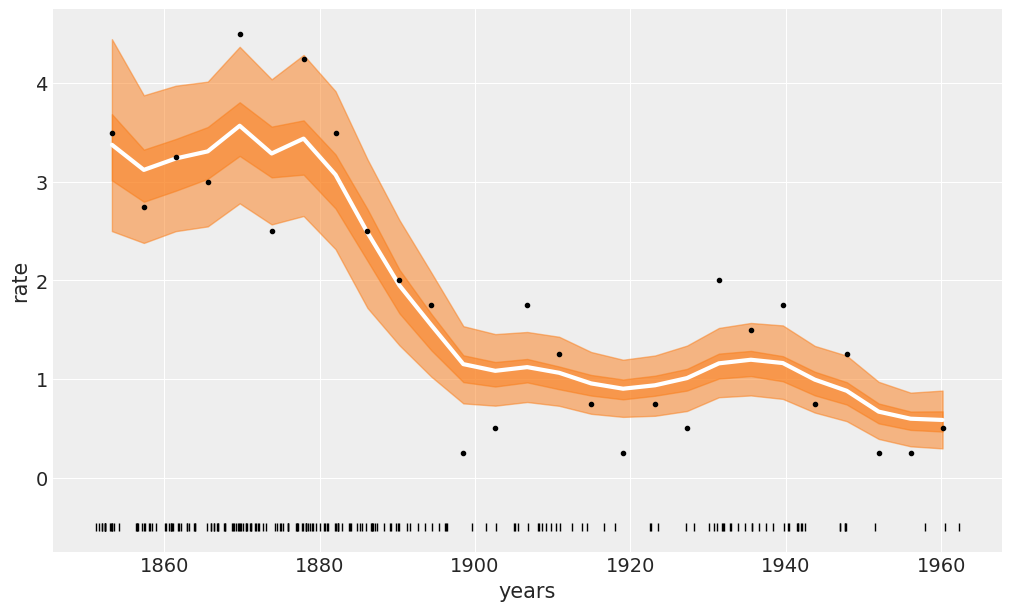

In [7]:
#
# Visualize fit
# ---------------------------------------------------------
# The underscore (_) is a common convention in Python for a variable name that we don't plan to use.

# plot settings
_, ax = plt.subplots(figsize=(10, 6)) 

# sample posterior distribution and calcualte mean
rates = idata_coal.posterior["μ"] / 4
rate_mean = rates.mean(dim=["draw", "chain"])

# plot specifications
ax.plot(x_centers, rate_mean, "w", lw=3)
ax.plot(x_centers, y_data / 4, "k.")
az.plot_hdi(x_centers, rates, smooth=False)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate");

####  Viualizign how an ensembnle of BART trees approximates a smooth function

The following figure shows two samples from the posterior of μ. Although these functions are not smooth, they illustrate how using regression trees is **a way to represent stepwise functions, which are particularly useful for representing situations where a quantity changes abruptly at specific points or intervals** This is useful  and a sum of stepwise functions is just another stepwise function. **So, when using BART we just need to know that we are assuming that a stepwise function is a good enough approximation for our problem.** 

In practice this is often the case because we sum over many trees, usually values like 50, 100, or 200. Additionally, we often average over the posterior distribution. All this makes the “steps smoother”, even when we never really have an smooth function as for example with Gaussian processes (splines). A nice theoretical result, tells us that in the limit of **m -> ∞** . The BART prior converges to a [nowheredifferentiable](https://en.wikipedia.org/wiki/Weierstrass_function) Gaussian process.

The following figure shows two samples of μ from the posterior.

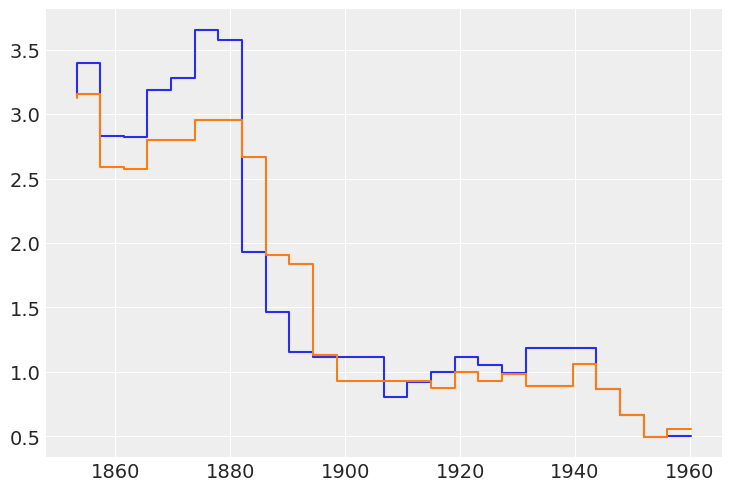

In [8]:
# simple illustration of two samples from the posterior of μ
# ----------
plt.step(x_data, 
         rates.sel(chain=0, draw=[3, 10]).T);

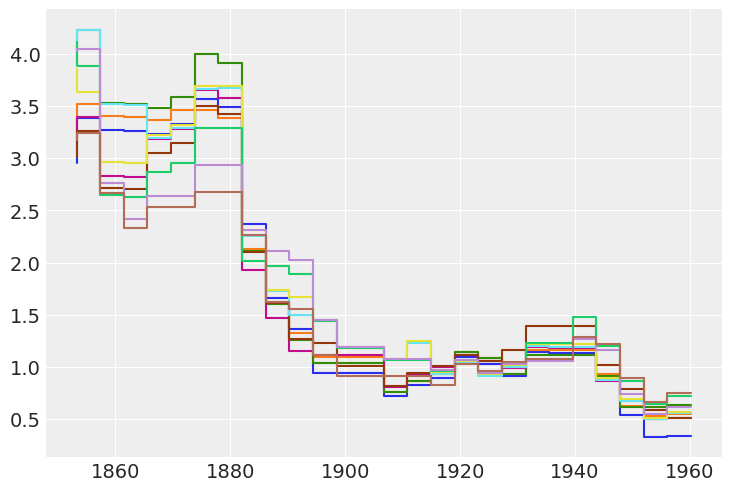

In [9]:
# what if we drew 10 samples?
# ----------
plt.step(x_data, 
         rates.sel(chain=0, draw=range(10)).T);

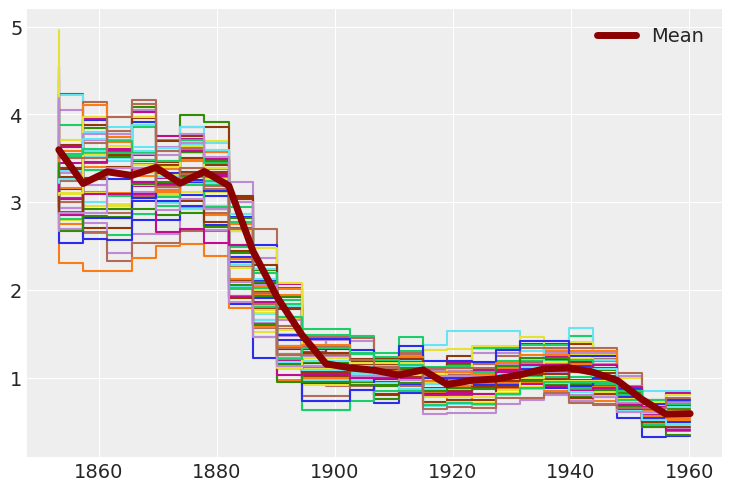

In [10]:
# what if we drew 50 samples and took the average?
# ----------

# Calculate the mean of the draws along the draw axis (axis=1)
mean_draws = rates.sel(chain=0, 
                       draw=range(50)).mean(dim='draw', skipna=True)

# Plot the step plot
plt.step(x_data, rates.sel(chain=0, 
                           draw=range(50)).T)

# Add the average line
plt.plot(x_data, 
         mean_draws, 
         color='#8B0000',
         linewidth=5, 
         label='Mean')

# Add legend
plt.legend()

# Show the plot
plt.show()


## Biking with BART

Now let's explore BART using four covariate using a subset of popular bike sharing dataset.
We will use the following variables: number of bike rental in a city, the hour of the day, the temperature, the humidity, and whether it is a weekday or weekend. 

To explore other features offered by BART in PyMC. We are now going to move on to a different example. In this example we have data about the  number of bikes rental in a city, and we have chosen four covariates; the hour of the day, the temperature, the humidity and whether is a workingday or a weekend. This dataset is a subset of the [bike_sharing_dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

### Data and pre-processing

In [11]:
#
# Load bike data
# ---------------------------------------------------------

# load data
# ---------
bikes = pd.read_csv(pm.get_data("bikes.csv"))  # the file bikes.csv is included in pymc installation
bikes.head()

,count,hour,temperature,humidity,workingday
0,16,0,0.24,0.81,0
1,28,0,0.70,0.79,1
2,128,0,0.60,0.88,0
3,29,0,0.62,0.78,1
4,52,0,0.62,0.94,1


In [12]:
# specify feature list for subsetting
# ---------
features = ["hour", 
            "temperature",
            "humidity",
            "workingday"]

# partition data
# ---------
X = bikes[features]
y = bikes["count"]

### Fit model


In [13]:
#
# Fit BART Model
# ---------------------------------------------------------

# Create a new probabilistic model
with pm.Model() as model_bikes:
    
    # Step 1: ...
    # ----------
    α = pm.Exponential("α", 
                       1)
    
    # Step 2: fit the model and store the output
    # ----------
    μ = pmb.BART("μ",             # store model output in "μ_" object
                 X,               # setting predictor data
                 np.log(y),       # setting outcome (normalizing by taking the logarithm)
                 m=50)            # This parameter defines the number of trees to used to sum over
    
    # Step 3: compare model with to get predictions
    # ----------
    y_pred = pm.NegativeBinomial("y",          # store model output in "y_pred" object
                            mu=pm.math.exp(μ), # parameter for the Poisson distribution representing the mean
                            alpha=α,           # 
                            observed=y)        # observed data that the model is conditioned 
     
    # Step 4: sample the posterior distribution of the model
    # ----------
    idata_bikes = pm.sample(compute_convergence_checks=False, 
                            random_seed=random_seed)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


### Convergence diagnostics

To check sampling convergence of BART models we recommend a 2 step approach. 

* For the non-BART variables (like $\alpha$ in `model_bikes`) we follow the standard recommendations, like checking R-hat (<= 1.01), and ESS (< 100x number of chains) numerical diagnostics as well as using trace plots or rankplots
* For the BART variables we recommend using the `pmb.plot_convergence` function. 

**Which diagnostics to check:**
Some argue in the BART literature that the diagnostics of the BART variables are less important than the diagnostics of the non-BART variables. The main argument is that the individual estimates of the latent variables are of no direct interest, and instead we should only care about how well we are estimating the whole function/regression.

However, the library mainatiners argue for checking the convergence of BART variables is an important part of the Bayesian workflow. The main reason to use `pmb.plot_convergence` is that usually the BART variable will be a large vector (we estimate a distribution per observation) and thus we will need to check a large number of diagnostics. 

Additionally, the R-hat threshold of 1.01 is not a hard threshold, this value was chosen assuming one or a few R-hats are examined (and chains are long enough to accurately estimate their autocorrelation), and if we observed a large number of R-hat a few of them are expected to be larger than the 1.01 threshold (or whatever threshold we pick) even if there is nothing wrong with our inference. For that reason, a fair analysis should include a multiple comparison adjustment, and that's what `pmb.plot_convergence` does automatically for you. 

**So, how to read its output?:** We have two panels one for ESS and one for the R-hat. The blue line is the empirical cumulative distribution for those values, for the ESS we want the entire curve above the dashed line, and for R-hat we want the curve to be entirely below the dashed line. In the previous figure, we can see that we barely make it for the ESS and for the R-hat we have very few values above the threshold. Are our results useless? Most likely not. But to be sure we may want to take a few more draws.  

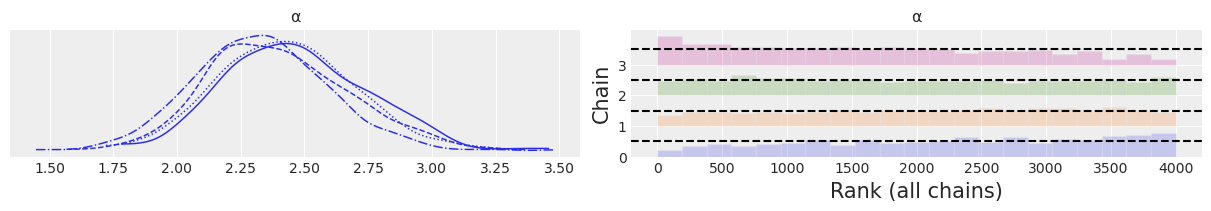

In [14]:
# checking non-BART models
# ----------
az.plot_trace(idata_bikes, 
              var_names=["α"], 
              kind="rank_bars");

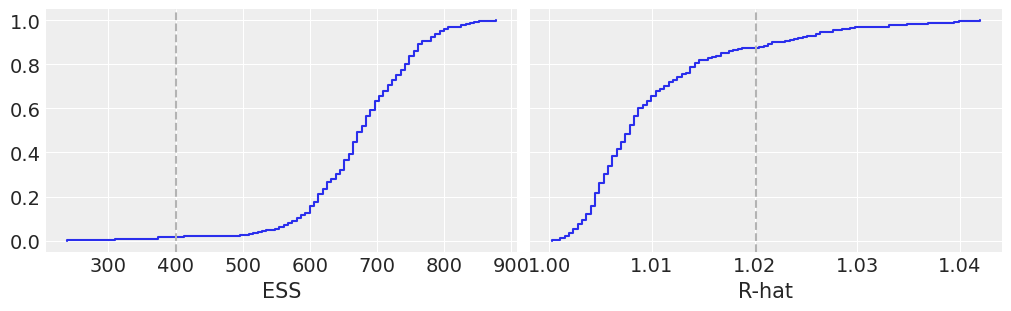

In [15]:
# checking BART variables 
# ----------
pmb.plot_convergence(idata_bikes, 
                     var_name="μ");

### Partial dependence plots

To help us interpret the results of our model we can use **partial dependence plots** (We covered these in the Lundberg et. al. paper). This is a type of plot that shows the *marginal effect that one covariate has on the predicted variable*. That is, what is the effect that a covariate $X_i$ has of $Y$ while we average over all the other covariates ($X_j, \forall j \not = i$). This type of plot are not exclusive of BART. But they are often used in the BART literature. PyMC-BART provides an utility function to make this plot from the inference data.

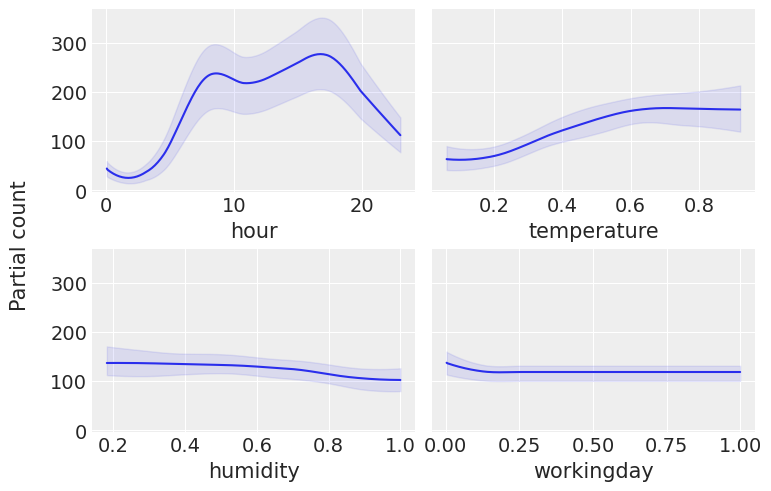

In [17]:
#
# partial dependence plots
# ---------------------------------------------------------

# explore plot_pdp function futher at https://github.com/pymc-devs/pymc-bart/blob/main/pymc_bart/utils.py
_ = pmb.plot_pdp(μ, X=X, Y=y, grid=(2, 2), func=np.exp);

From this plot we can see the main effect of each covariate on the predicted value. This is very useful as we can recover complex relationship beyond monotonic increasing or decreasing effects. For example for the `hour` covariate we can see two peaks around 8 and and 17 hs and a minimum at midnight.

When interpreting partial dependence plots we should be careful about the assumptions in this plot. **First,** we are assuming variables are independent. For example when computing the effect of `hour` we have to marginalize the effect of `temperature` and this means that to compute the partial dependence value at `hour=0` we are including all observed values of temperature, and this may include temperatures that are actually not observed at midnight, given that lower temperatures are more likely than higher ones. We are seeing only averages, so if for a covariate half the values are positively associated with predicted variable and the other half negatively associated. The partial dependence plot will be flat as their contributions will cancel each other out. This is a problem that can be solved by using individual conditional expectation plots `pmb.plot_dependence(..., kind="ice")`. **Notice that all of these assumptions are assumptions of the partial dependence plot, not of our model!** In fact BART can easily accommodate interaction of variables. Although the prior in BART regularizes high order interactions. 

*For more on interpreting Machine Learning model you could check the "[Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)"*.

Finally like with other regression methods we should be careful that the effects we are seeing on individual variables are conditional on the inclusion of the other variables. So for example, while `humidity` seems to be mostly flat, meaning that this covariate has an small effect of the number of used bikes. This could be the case because `humidity` and `temperature` are correlated to some extend and once we include `temperature` in our model `humidity` does not provide too much extra information. Try for example fitting the model again but this time with `humidity` as the single covariate and then fitting the model again with `hour` as a single covariate. You should see that the result for this single-variate models will very similar to the previous figure for the `hour` covariate, but less similar for the `humidity` covariate.

### Variable importance

As we saw in the previous section a partial dependence plot can visualize give us an idea of how much each covariable contributes to the predicted outcome. But BART itself leads to a simple heuristic to estimate variable importance. That is simple count how many times a variable is included in all the regression trees. The intuition is that if a variable is important they it should appears more often in the fitted trees that less important variables. While this heuristic seems to provide reasonable results in practice, there is not too much theory justifying this procedure, at least not yet.

The following plot shows the relative importance in a scale from 0 to 1 (less to more importance) and the sum of the individual importance is 1. At least in this case, the relative importance qualitative agrees with the partial dependence plot in that `hour` seems to be the most important variable. After we begin to lose relative importance.

Additionally, PyMC-BART provides a novel method to assess the variable importance. You can see an example in the bottom panel. On the x-axis we have the number of covariables and on the y-axis the square of the Pearson correlation coefficient between the predictions made for the full-model (all variables included) and the restricted-models, those with only a subset of the variables. The components are included following the relative variable importance order, as show in the top panel. Thus, in this example "number of covariables" is 1 `hour`, 2  `hour` and `temperature`, 3 `hour`, `temperature`and `humidity`. Finally, 4 means `hour`, `temperature`, `humidity`, `workingday`, i.e., the full model. Hence, from the next figure we can see that even a model with a single component, `hour`, is very close to the full model. Even more, the model with two components `hour`, and `temperature` is on average indistinguishable from the full model. The error bars represent the 94 \% HDI from the posterior predictive distribution. It is important to notice that to compute these correlations we do not resample the models, instead the predictions of the restricted-models are approximated by *prunning* variables from the full-model.

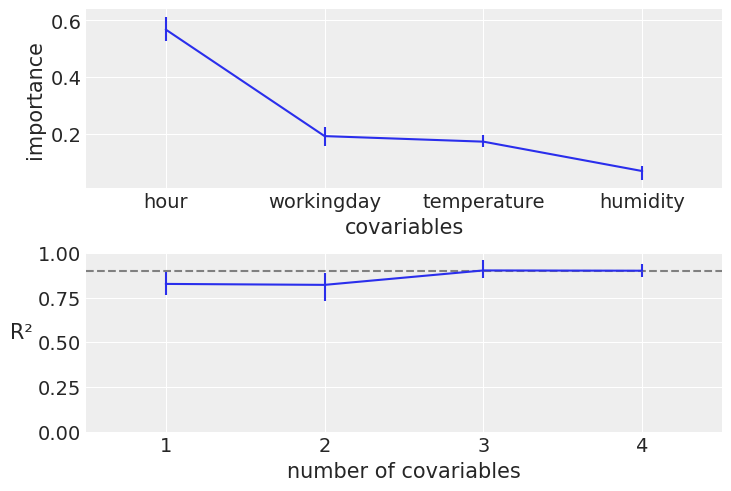

In [18]:
#
# variable importance 
# ---------------------------------------------------------

pmb.plot_variable_importance(idata_bikes,  # set the data frame
                             μ,            # set 
                             X,            # set the feastures to model
                             samples=100); # how many samples do we want to draw

### Out-of-Sample Predictions

In this section we want to show how to do out-of-sample predictions with BART. We are going to use the same dataset as before, but this time we are going to split the data into a training and a test set. We are going to use the training set to fit the model and the test set to evaluate the model.

#### Regression

Let's start by modelling this data as a regression problem. In this context we randomly split the data into a training and a test set.

In [19]:
#
# split into training and test data
# ---------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=random_seed)

Now, we fit the same model as above but this time using a *shared variable* for the covariatates so that we can then replace them to generate the out of sample predictions.

In [21]:
#
# split into training and test data
# ---------------------------------------------------------


with pm.Model() as model_oos_regression:
    X = pm.MutableData("X", X_train)
    y = y_train
    α = pm.Exponential("α", 1)
    μ = pmb.BART("μ", X, np.log(y))
    y_pred = pm.NegativeBinomial("y", mu=pm.math.exp(μ), 
                            alpha=α, 
                            observed=y, 
                            shape=μ.shape)
    
    idata_oos_regression = pm.sample(random_seed=random_seed)
    
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_oos_regression, 
        random_seed=random_seed
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [α]
>PGBART: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y]


Finally, we can compare the posterior predictive distribution with the observed data.

In [22]:
#
# make posterior predictions
# ---------------------------------------------------------

with model_oos_regression:
    X.set_value(X_test)
    posterior_predictive_oos_regression_test = pm.sample_posterior_predictive(
        trace=idata_oos_regression, random_seed=random_seed
    )

Sampling: [y, μ]


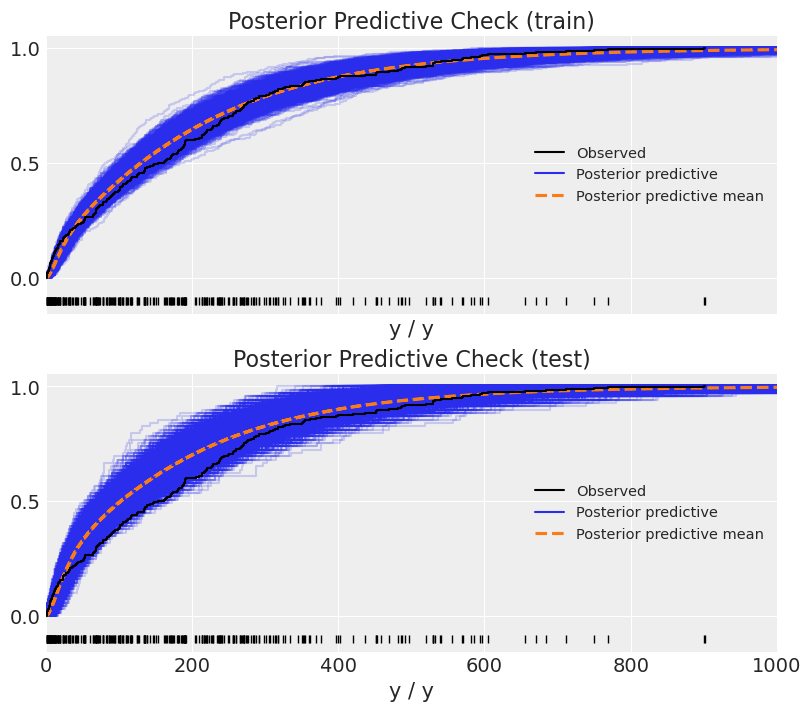

In [23]:
#
# check posterior predictions on training and testdata
# ---------------------------------------------------------

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 7), sharex=True, sharey=True, layout="constrained"
)

# training
# -----------
az.plot_ppc(
    data=posterior_predictive_oos_regression_train, kind="cumulative", observed_rug=True, ax=ax[0]
)

ax[0].set(title="Posterior Predictive Check (train)", xlim=(0, 1_000))

# training
# -----------
az.plot_ppc(
    data=posterior_predictive_oos_regression_test, kind="cumulative", observed_rug=True, ax=ax[1]
)
ax[1].set(title="Posterior Predictive Check (test)", xlim=(0, 1_000));

Yay! The results look quite reasonable 🙂!

### Acknowledgement
The lab was adapted from the following official documentation in PyMC and acknowledge their work in building out  the library and this helpful tutorial, which can be [viewed here](https://www.pymc.io/projects/examples/en/latest/case_studies/BART_introduction.html). Please explore the official documentation if you want to learn more. 